# Параметр Тумре

In [12]:
import os
%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [13]:
import numpy as np
import scipy.interpolate as inter

In [14]:
import functions

In [20]:
Distance = 10.57 # Mpc
incl = 62.
cosi = np.cos(incl / 180. * np.pi)
sini = np.sin(incl / 180. * np.pi)

In [21]:
sigma_s = np.load('sigma_s.npy')
H_alpha = np.load('H_alpha.npy')
Sigma_H2 = np.load('Sigma_H2.npy')
sigma_HI = np.load('sigma_HI.npy')
Sigma_HI = np.load('Sigma_HI.npy')
Sigma_s = np.load('Sigma_s.npy')
sig_R_max = np.load('sig_R_max.npy')
sig_R_min = np.load('sig_R_min.npy')
r_HI = np.load('r_HI.npy')
vel_HI = np.load('vel_HI.npy')
kappa = np.load('kappa.npy')
dist_kpc = np.load('dist_kpc.npy')

In [22]:
velocity_approx = poly1d(polyfit(r_HI, vel_HI, deg=4))

In [45]:
from scipy.special import i0e, i1e
from scipy.optimize import brentq
def findInvKinemQeffBrentq(Qs, Qg, s, krange):
    '''Решение уравнения deriv(13) = 0 для нахождения максимума исходной функции. Запускается brentq на исходной сетке,
    в случае если на концах сетки разные знаки функции (промежуток содержит корень),
    затем выбираются лучшие корни, после чего ищется, какой их них дает максимум. Возвращается только этот корень.'''
    grid = krange
    args = [Qs, Qg, s]
    signs = [derivTwoFluidKinemQeff(x, *args) for x in grid]
    signs = [x/abs(x) for x in signs]
    roots = []
    for i in range(len(signs)-1):
        if signs[i] * signs[i + 1] < 0:
            roots.append(brentq(lambda x: derivTwoFluidKinemQeff(x, *args), grid[i], grid[i + 1]))
    original = [inverse_kinem_Qeff_from_k(l, Qg=Qg, Qs=Qs, s=s) for l in roots]
    root_for_max = roots[original.index(max(original))]
    if abs(root_for_max-krange[-1]) < 0.5:
        print ('WARNING! For Qs={} Qg={} s={} root of max near the max of k-range')
        format(Qs, Qg, s)
    return (root_for_max, max(original))

def inverse_kinem_Qeff_from_k(dimlK, Qg=None, Qs=None, s=None):
    return 2. / dimlK / Qs * (1 - i0e(dimlK ** 2)) + 2*s*dimlK / Qg / (1 + dimlK**2 * s**2)

def derivTwoFluidKinemQeff(dimlK, Qs, Qg, s):
    '''Производная по \bar{k} от левой части (13) для того, чтобы найти максимум. Коррекция за ассимптотику производится
    с помощью встроенных функций бесселя, нормированных на exp.'''
    part1 = (1 - i0e(dimlK ** 2)) / (-dimlK ** 2)
    part2 = (2 * dimlK * i0e(dimlK ** 2) - 2 * dimlK * i1e(dimlK ** 2)) / dimlK
    part3 = (1 - (dimlK * s) ** 2) / (1 + (dimlK * s) ** 2) ** 2
    return 2 * (part1 + part2) / Qs + 2 * s * part3 / Qg

In [50]:
dR =(Distance*1000*2*np.pi)/(360*60*60.)
G = 4.32
Qeff_max = np.zeros(dist_kpc.shape)
Qeff_min = np.zeros(dist_kpc.shape)
bark = np.zeros(dist_kpc.shape)
bark_max = np.zeros(dist_kpc.shape)
Qg = np.zeros(dist_kpc.shape)
Qs_min = np.zeros(dist_kpc.shape)
Qs_max = np.zeros(dist_kpc.shape)
Sigma_g = np.zeros(dist_kpc.shape)

step = 0
errors = 0
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        step+=1
        if step % 1000 == 0:
            print(step)
        c = sigma_HI[i][j]/1000.
        Sigma_g[i][j] = 1.36*(Sigma_HI[i][j] + Sigma_H2[i][j])
        kappa = functions.epic_freq(velocity_approx, dist_kpc[i][j], dR)
        Sigma_s_ = Sigma_s[i][j]
        s_R_max = sig_R_max[i][j]
        s_R_min = sig_R_min[i][j]
        Qg[i][j] = kappa * c / (math.pi * G * Sigma_g[i][j])
        Qs_max[i][j] = kappa * s_R_max / (3.36 * G * Sigma_s_)
        Qs_min[i][j] = kappa * s_R_min / (3.36 * G * Sigma_s_)
        
       
        try:
            root_for_max, qeff = findInvKinemQeffBrentq(Qs_min[i][j], Qg[i][j], c/s_R_min, np.arange(0.01, 50., 1.))
        except ValueError:
            errors+=1
            qeff = 0.01
            root_for_max = -1.
        Qeff_min[i][j] = 1./qeff
        bark[i][j] = root_for_max
        
        try:
            root_for_max, qeff = findInvKinemQeffBrentq(Qs_max[i][j], Qg[i][j], c/s_R_min, np.arange(0.01, 50., 1.))
        except ValueError:
            errors+=1
            qeff = 0.01
            root_for_max = -1.
        Qeff_max[i][j] = 1./qeff
        bark_max[i][j] = root_for_max
      
        
        
print('Errors:{}'.format(errors))

/home/lera/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Errors:4704


Text(0.5, 1.0, '$\\bar{k}$')

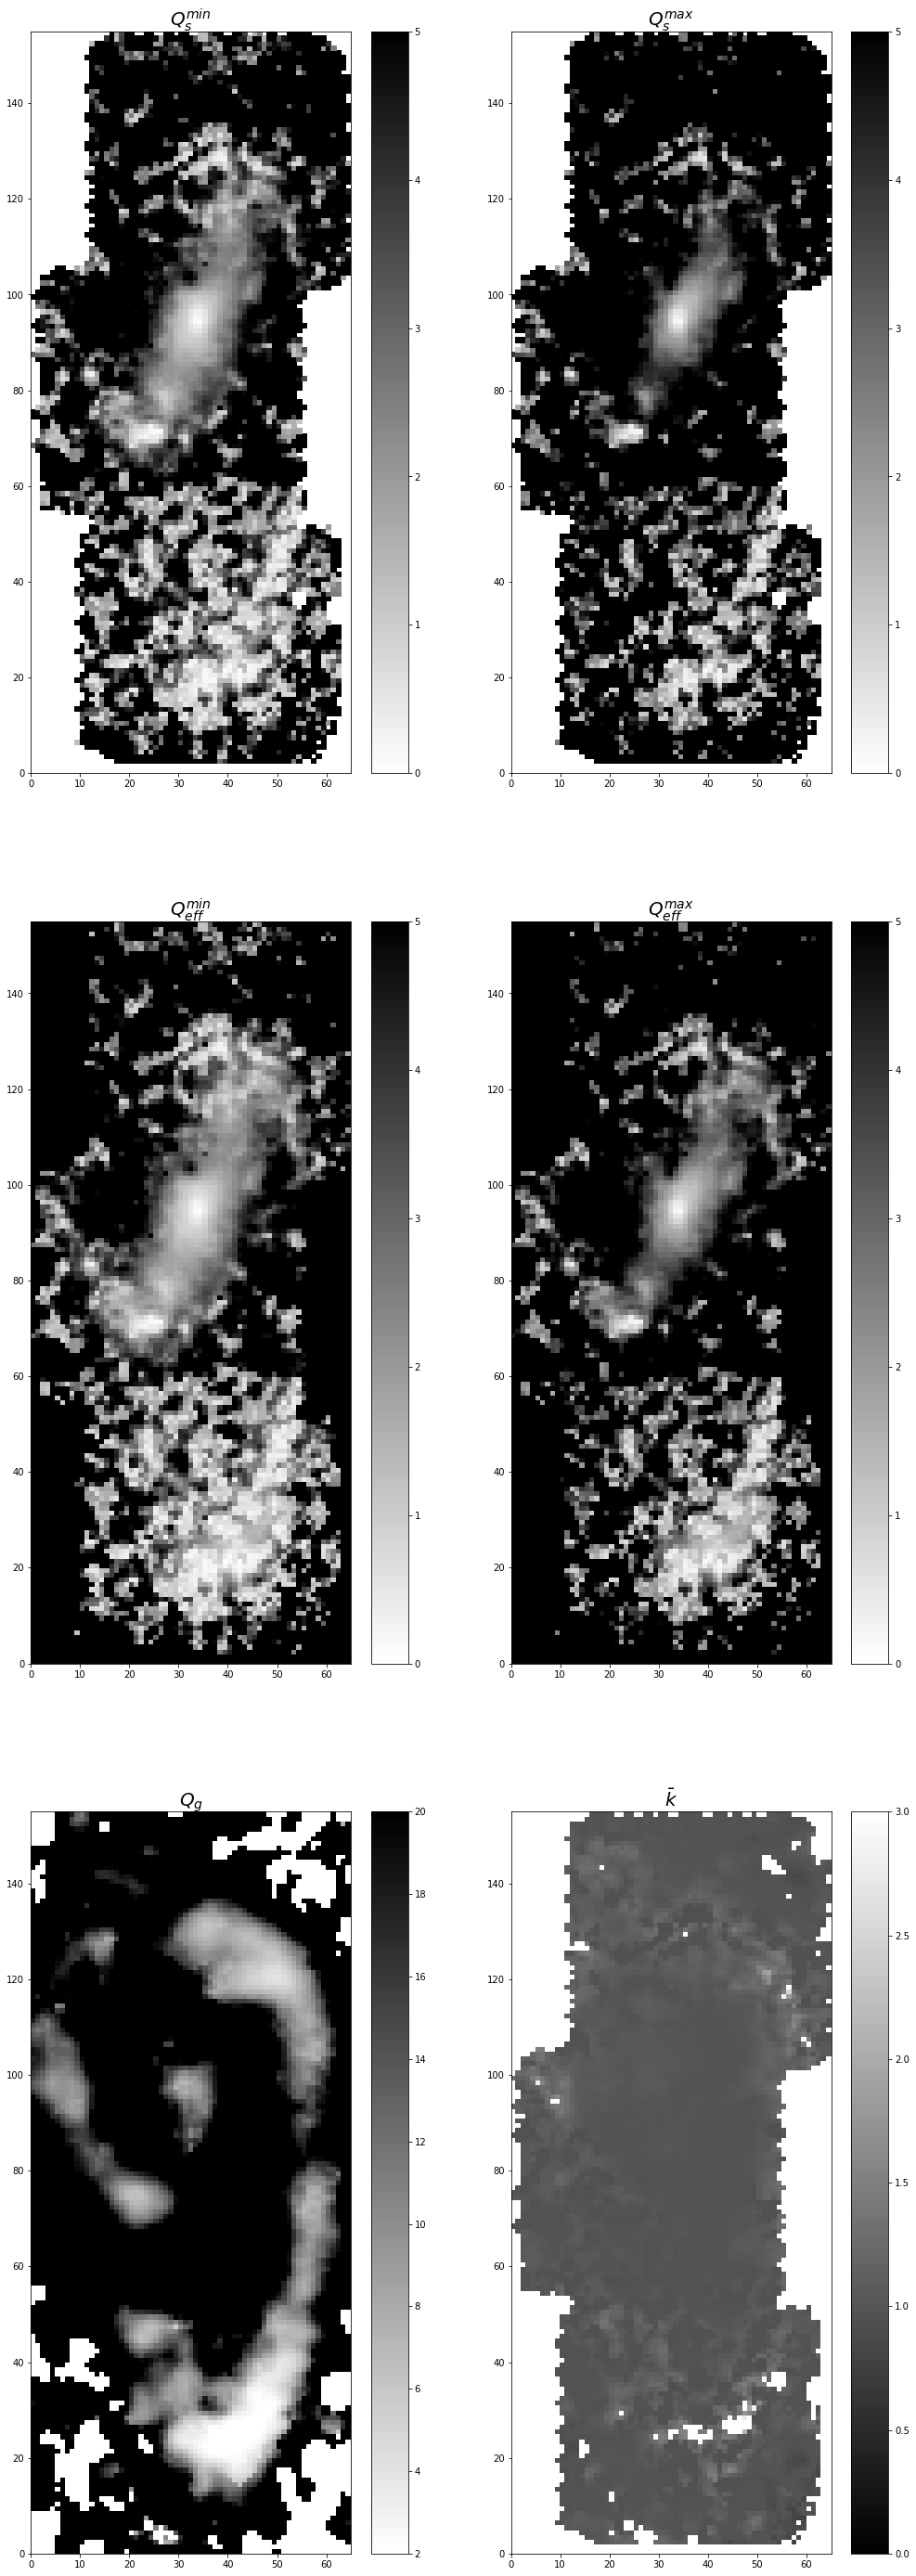

In [78]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 50])
plt.subplot(3,2,1)
quadmesh = plt.pcolormesh(X, Y, Qs_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=5.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{s}^{min}$', fontsize=20)

plt.subplot(3,2,2)
quadmesh = plt.pcolormesh(X, Y, Qs_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=5.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{s}^{max}$', fontsize=20)

plt.subplot(3,2,3)
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=0.0, vmax=5.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(3,2,4)
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=0.0, vmax=5.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)

plt.subplot(3,2,5)
quadmesh = plt.pcolormesh(X, Y, Qg, cmap='gist_yarg')
quadmesh.set_clim(vmin=2., vmax=20.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{g}$', fontsize=20)

plt.subplot(3,2,6)
quadmesh = plt.pcolormesh(X, Y, bark, cmap='gray')
quadmesh.set_clim(vmin=0., vmax=3.)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$\bar{k}$', fontsize=20)